# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [2]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [3]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48673, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [4]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables utiles para visualizaciones

In [5]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48673 entries, 0 to 48672
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48673 non-null  datetime64[ns]
 1   home_team    48673 non-null  object        
 2   away_team    48673 non-null  object        
 3   home_score   48673 non-null  int64         
 4   away_score   48673 non-null  int64         
 5   tournament   48673 non-null  object        
 6   city         48673 non-null  object        
 7   country      48673 non-null  object        
 8   neutral      48673 non-null  bool          
 9   year         48673 non-null  int32         
 10  month        48673 non-null  int32         
 11  dayofweek    48673 non-null  int32         
 12  is_weekend   48673 non-null  int64         
 13  goal_diff    48673 non-null  int64         
 14  total_score  48673 non-null  int64         
 15  result       48673 non-null  object        
dtypes: b

In [7]:
results.describe()

,date,home_score,away_score,year,month,dayofweek,is_weekend,goal_diff,total_score
count,48673,48673.000000,48673.000000,48673.000000,48673.000000,48673.000000,48673.000000,48673.000000,48673.000000
mean,1993-11-20 00:23:08.137160192,1.757874,1.181743,1993.357488,6.892692,3.455222,0.395435,1.716804,2.939617
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1980-03-22 00:00:00,1.000000,0.000000,1980.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,2000-04-02 00:00:00,1.000000,1.000000,2000.000000,7.000000,3.000000,0.000000,1.000000,3.000000
75%,2012-12-03 00:00:00,2.000000,2.000000,2012.000000,10.000000,5.000000,1.000000,2.000000,4.000000
max,2025-10-14 00:00:00,31.000000,21.000000,2025.000000,12.000000,6.000000,1.000000,31.000000,31.000000
std,NaN,1.772685,1.401651,25.322517,3.228201,1.982141,0.488949,1.791873,2.094691


#### Visualizaciones de variables numéricas

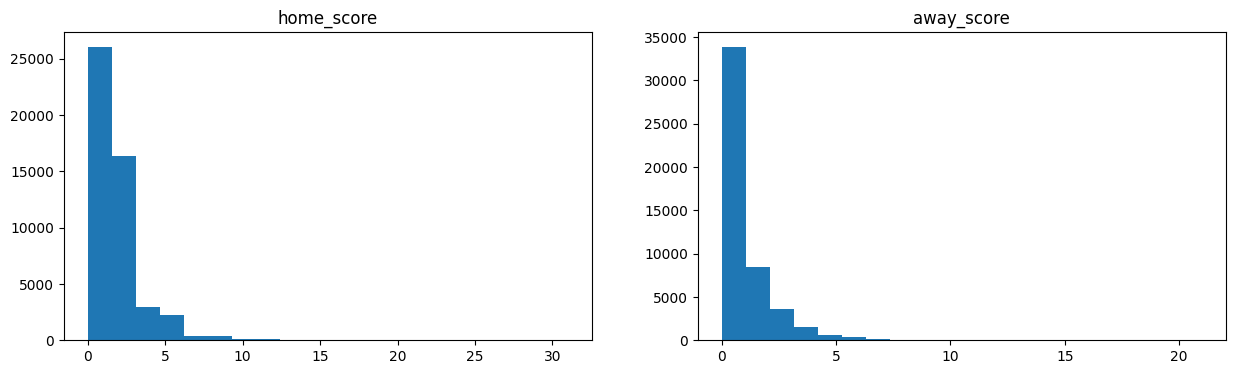

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

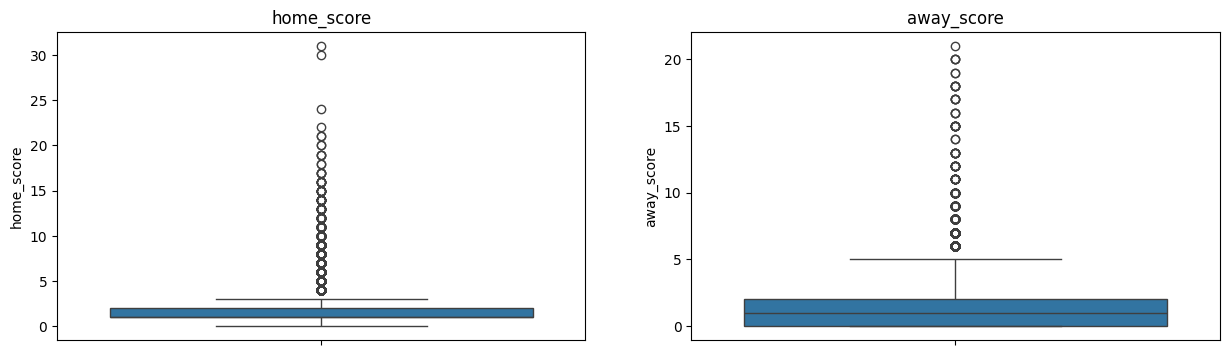

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

📝 Si bien existen outliers, estos no pueden tratarse como errores ya que son resultados reales de partidos de fútbol.

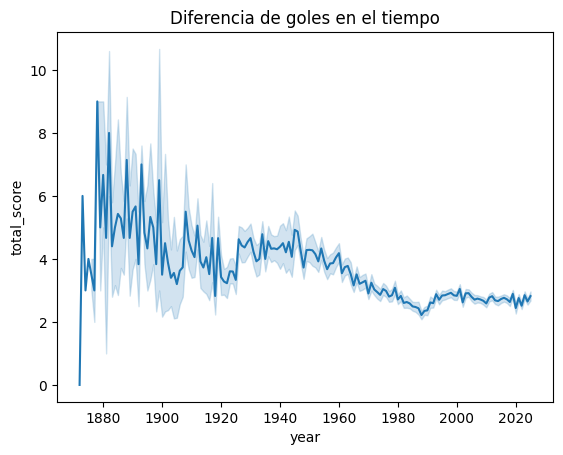

In [10]:
sns.lineplot(data=results, x="year", y="total_score")
plt.title("Diferencia de goles en el tiempo")
plt.show()

📝 Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

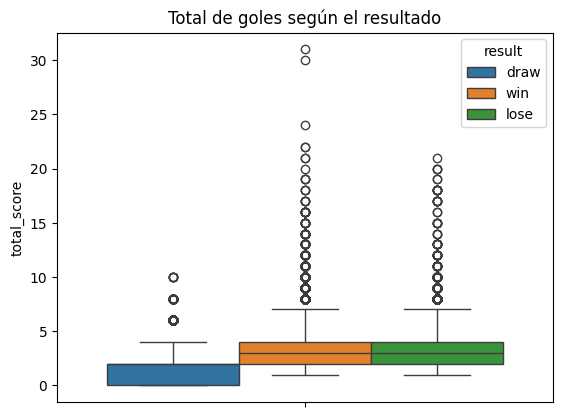

In [11]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

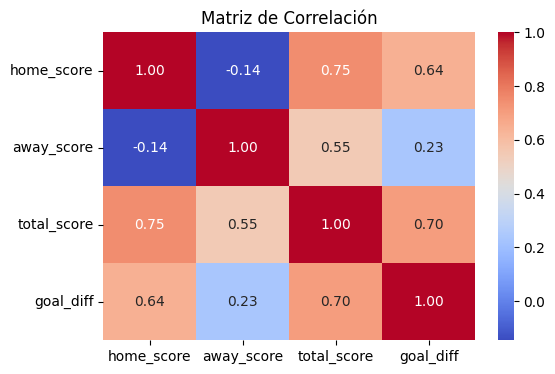

In [12]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

#### Visualización de variables categoricas

In [13]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')


In [14]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48673,48673,48673,48673,48673,48673
unique,325,318,188,2119,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,579,18151,737,1464,23869


Veamos la distribución del target

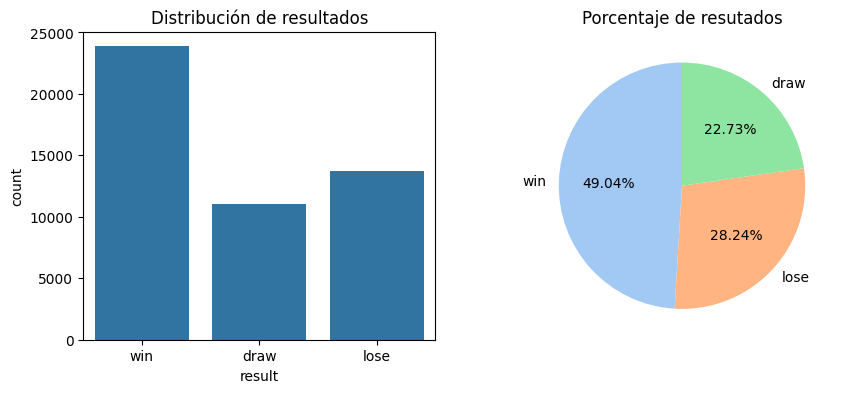

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

📝 A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

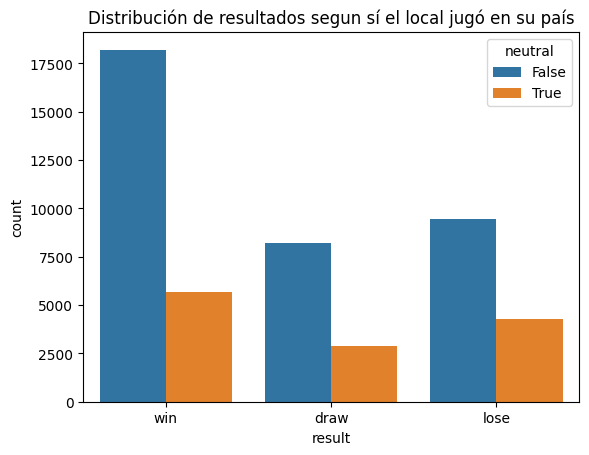

In [16]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

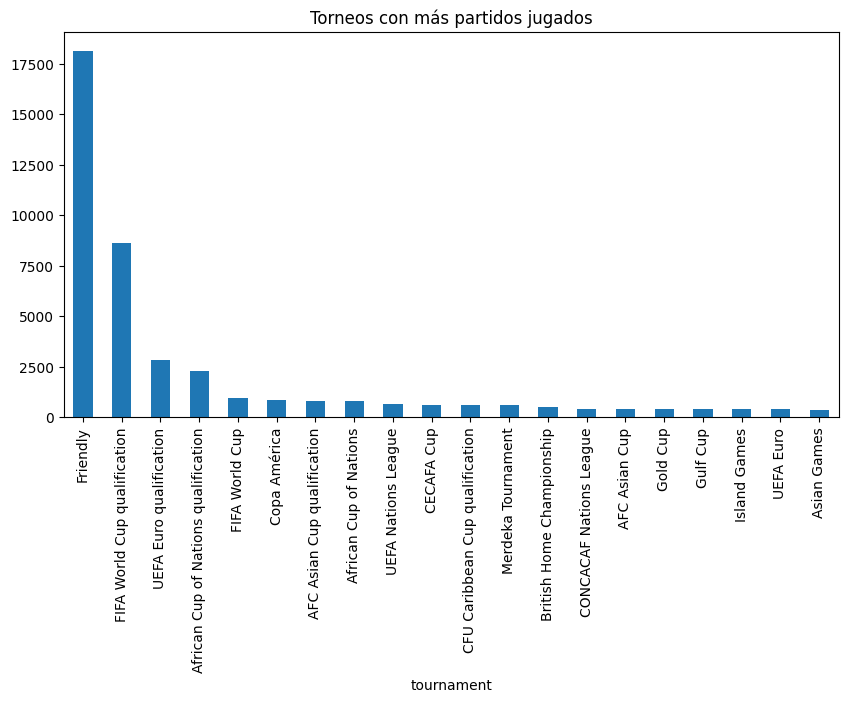

In [17]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

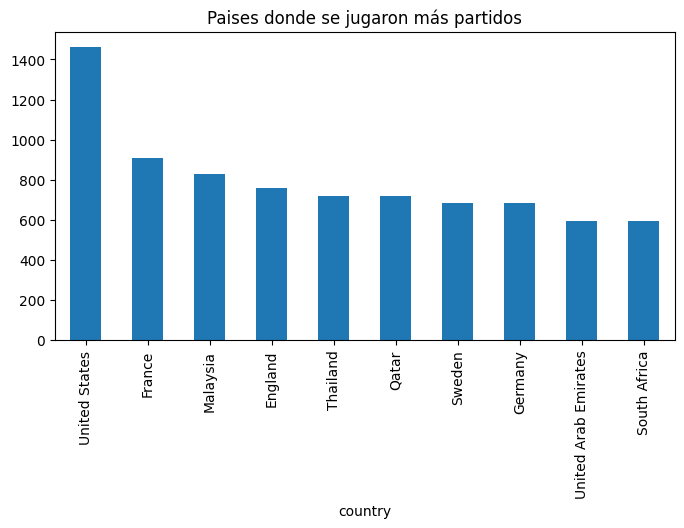

In [18]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

📝 De los torneos, se destaca el tipo "amistoso" pero también aparecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial. La cardinalidad de los torneos puede influir al momento de evaluar los modelos.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

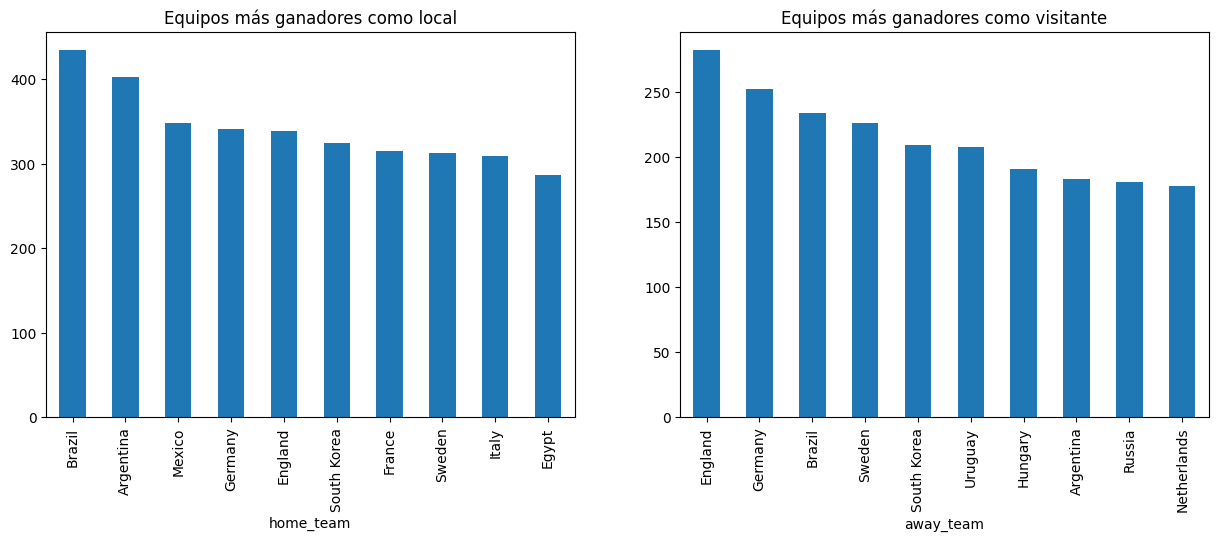

In [19]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

📝 Como no hay muchas variables representativas que permitan hacecr predicciones, vamos a basarnos en el rating elo de los dos equipos y la diferencia entre ambos.

Para más detalles sobre el funcionamiento del sistema Elo y su aplicación en el ranking de equipos: [World Football Elo Ratings](https://en.wikipedia.org/wiki/World_Football_Elo_Ratings).

En este proyecto se asigna un valor inicial (1500) a cada equipo y se aplica un factor de ajuste (K = 20) para actualizar los ratings tras cada partido, considerando además una ventaja local de 80 puntos. De esta manera se puede usar la función "compute_elo_features". para obtener la diferencia de ratings entre el equipo local y el equipo visitante.

In [20]:
from collections import deque
from math import log

# Parámetros 
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0           # ventaja local en puntos ELO
half_life_years = 2.0     # half-life (2 o 3 años suelen andar muy bien)
half_life_days  = 365.0 * half_life_years
N_prev = 20               # ← cantidad de partidos “hacia atrás” por equipo

# Pesos por torneo (ajustables). Default = 1.1 como pediste.
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2,
    "Friendly": 0.9,
}
def w_tournament(t):
    return weights.get(t, 1.1)  # ← default sensato

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

def compute_elo_features(df):
    """Calcula ELO de forma cronológica."""
    ratings, last_played, recent_counts = {}, {}, {}
    snapshots = []

    df = df.sort_values("date").copy()
    for _, row in df.iterrows():
        d, ht, at = row["date"], row["home_team"], row["away_team"]
        hs, as_, tour, neut = row["home_score"], row["away_score"], row["tournament"], bool(row["neutral"])

        for team in (ht, at):
            if team not in ratings: ratings[team] = R0
            if team not in recent_counts: recent_counts[team] = deque(maxlen=N_prev)
            if team in last_played:
                delta_days = (d - last_played[team]).days
                if delta_days > 0:
                    decay = 0.5 ** (delta_days / half_life_days)
                    ratings[team] = R0 + (ratings[team] - R0) * decay

        Rh_pre, Ra_pre = ratings[ht], ratings[at]  # ratings antes del partido
        home_adv = 0 if neut else HOME_ADV
        Eh = elo_expect(Rh_pre, Ra_pre, home_adv)
        Ea = 1 - Eh

        # Resultado
        if hs > as_: Sh, Sa = 1, 0
        elif hs < as_: Sh, Sa = 0, 1
        else: Sh, Sa = 0.5, 0.5

        margin = max(1, log(1 + abs(hs - as_), 2))
        Kw_base = K_base * w_tournament(tour) * margin
        cnt_h, cnt_a = len(recent_counts[ht]), len(recent_counts[at])
        factor_h, factor_a = min(1, cnt_h / N_prev), min(1, cnt_a / N_prev)
        Kw_h, Kw_a = Kw_base * (0.5 + 0.5 * factor_h), Kw_base * (0.5 + 0.5 * factor_a)

        # Actualizamos después del partido
        ratings[ht] = Rh_pre + Kw_h * (Sh - Eh)
        ratings[at] = Ra_pre + Kw_a * (Sa - Ea)

        recent_counts[ht].append(d)
        recent_counts[at].append(d)
        last_played[ht], last_played[at] = d, d

        # Guardamos el snapshot usando los ratings previos al partido
        snapshots.append({
            "date": d,
            "home_team": ht,
            "away_team": at,
            "home_rating": Rh_pre,
            "away_rating": Ra_pre
        })

    elo_df = pd.DataFrame(snapshots)
    elo_df["rating_diff"] = elo_df["home_rating"] - elo_df["away_rating"]
    return elo_df

📝 En base al analisis previo, se decide filtrar los datos a partir de 1920. Antes de esa fecha, había más diferencia entre los equipos (mayor diferencia de goles).

Otros filtros a considerar que podrían introducir ruido en el modelo:
* Cardinalidad de los torneos: existen demasiados torneos por lo cual podría ser conveniente centrarse en los mas conocidos.

También creamos la variable target {1: "win", 0: "draw", -1: "loss"} y las variables
Y creamos nuevas features a partir de la fecha.

📝 Como el objetivo es predecir el resultado del partido, no podemos usar los registros como tal ya que estos son posteriores al partido. Por lo tanto, se crean la variable elo_df que representa la diferencia en el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*.

In [21]:
results_filtered = results[results["year"] >= 1920].reset_index(drop=True)

print("Original", results.shape)
print("Filtrado", results_filtered.shape)

# Nuevas features
results_filtered["goal_diff"] = results_filtered["home_score"] - results_filtered["away_score"]
sign_map = {1: "win", 0: "draw", -1: "loss"}

results_filtered["target"] = np.sign(results_filtered["goal_diff"]).map(sign_map)

results_filtered["year"] = results_filtered["date"].dt.year
results_filtered["month"] = results_filtered["date"].dt.month
results_filtered["dayofweek"] = results_filtered["date"].dt.dayofweek
results_filtered["neutral"] = results_filtered["neutral"].astype(int)

# Probamos usando codificación de variables cíclicas pero no fueron útiles
# results_filtered["year_sin"] = np.sin(2*np.pi*results_filtered["year"]/4)
# results_filtered["year_cos"] = np.cos(2*np.pi*results_filtered["year"]/4)
# results_filtered["month_sin"] = np.sin(2*np.pi*results_filtered["month"]/12)
# results_filtered["month_cos"] = np.cos(2*np.pi*results_filtered["month"]/12)
# results_filtered["day_sin"] = np.sin(2*np.pi*results_filtered["dayofweek"]/7)
# results_filtered["day_cos"] = np.cos(2*np.pi*results_filtered["dayofweek"]/7)

# Calcular ELO
elo_df = compute_elo_features(results_filtered)
results_with_rating = results_filtered.merge(
    elo_df, on=["date", "home_team", "away_team"], how="left"
)

Original (48673, 16)
Filtrado (48079, 16)


In [22]:
print("Nulos en base al procesamiento:\n", results_filtered.isna().sum()[results_filtered.isna().sum() > 0])

Nulos en base al procesamiento:
 Series([], dtype: int64)


No aparecen valores nulos después de los cálculos.

Hacemos el split del dataset y codificamos las variables categoricas:
- year, month y dayofweek ya se codificaron mediante cycling encoding pero no tuvieron peso en relación a las predicciones.
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta

Finalmente, se estandarizan las variables para que todas tengan la misma escala.

In [23]:
results_filtered.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result,target
0,1920-01-18,Italy,France,9,4,Friendly,Milan,Italy,0,1920,1,6,1,5,13,win,win
1,1920-02-14,Northern Ireland,Wales,2,2,British Home Championship,Belfast,Ireland,0,1920,2,5,1,0,4,draw,draw
2,1920-02-26,Wales,Scotland,1,1,British Home Championship,Cardiff,Wales,0,1920,2,3,0,0,2,draw,draw
3,1920-02-29,Switzerland,France,0,2,Friendly,Geneva,Switzerland,0,1920,2,6,1,-2,2,lose,loss
4,1920-03-13,Scotland,Northern Ireland,3,0,British Home Championship,Glasgow,Scotland,0,1920,3,5,1,3,3,win,win


In [24]:

# Features
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]

X = results_with_rating[feat_cat + feat_num]
y = results_with_rating["target"]

X.tail()

,home_team,away_team,tournament,neutral,year,month,dayofweek,rating_diff
48080,Republic of Ireland,Armenia,FIFA World Cup qualification,0,2025,10,1,83.842277
48081,Estonia,Moldova,FIFA World Cup qualification,0,2025,10,1,0.223943
48082,Italy,Israel,FIFA World Cup qualification,0,2025,10,1,90.894604
48083,Andorra,Serbia,FIFA World Cup qualification,0,2025,10,1,-174.619729
48084,Latvia,England,FIFA World Cup qualification,0,2025,10,1,-287.323500


In [25]:

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Codificacion y standarización
pre = ColumnTransformer(
    transformers=[
        
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", StandardScaler(), feat_num)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

📝 Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación para hacer un analisis comparativo y ver cual se adapta mejor al problema.


Top 10 importancias:
away_team      1.167081
home_team      1.162034
tournament     0.960062
rating_diff    0.335311
neutral        0.105411
year           0.060115
dayofweek      0.015977
month          0.008723
dtype: float64


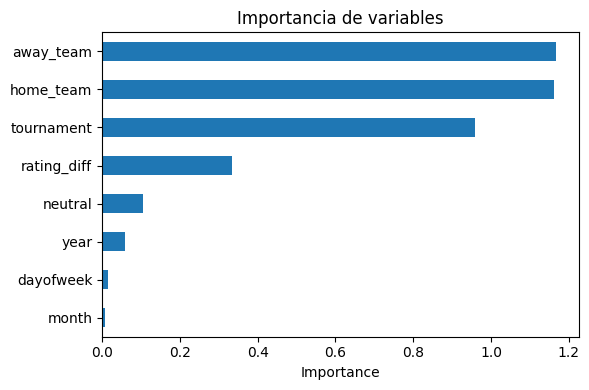

In [26]:
# Logistic Regression

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_logreg = clf.predict(X_te)
y_proba_logreg = clf.predict_proba(X_te)

# Importancia de features
try:
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    feature_names = np.array(["home_team_TE","away_team_TE","tournament_TE"] + feat_num)

importances = pd.Series(np.mean(np.abs(clf.named_steps["model"].coef_), axis=0), index=feature_names).sort_values(ascending=False)

print("\nTop 10 importancias:")
print(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Importancia de variables")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [27]:
# KNN

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", KNeighborsClassifier(
        n_neighbors=21, metric="minkowski", p=2
    ))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_knn = clf.predict(X_te)
y_proba_knn = clf.predict_proba(X_te)

In [28]:
# SVM

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", SVC(C=5, kernel="rbf", decision_function_shape='ovr', probability=True))
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_svm = clf.predict(X_te)
y_proba_svm = clf.predict_proba(X_te)

In [29]:
# Arbol de decisión

clf = Pipeline(steps=[
    ("pre", pre),
    ("model", DecisionTreeClassifier(
        criterion='entropy', 
        splitter='best', 
        max_depth=10,
        min_samples_split=8,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42)
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_dtc = clf.predict(X_te)
y_proba_dtc = clf.predict_proba(X_te)

In [30]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
clf = Pipeline(steps=[
    ("pre", pre),
    ("model", RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
    )
])

# Fit
clf.fit(X_tr, y_tr)

# Predicciones
y_pred_rfc = clf.predict(X_te)
y_proba_rfc = clf.predict_proba(X_te)

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

In [31]:
# Funcion para imprimir resultados de clasificación
def print_classification_results(y_test, y_pred, model_name):
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=["draw", "lose", "win"],
                              zero_division=0))
    plot_normalized_confusion(y_test, y_pred)
    
def plot_normalized_confusion(y_true, y_pred, labels=["win", "draw", "loss"],
                              title="Matriz de confusión", figsize=(4.5, 4)):
    # Matriz de confusión normalizada
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=figsize)
    disp.plot(values_format=".2f", cmap=None, colorbar=False)
    plt.title(title)
    plt.show()

📝 En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar en la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global y log loss.


Resultados para Regresión Logística:

Accuracy: 0.5249038161588853
F1-score (macro): 0.48716947409882483

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.30      0.29      2194
        lose       0.49      0.57      0.53      2710
         win       0.69      0.60      0.64      4713

    accuracy                           0.52      9617
   macro avg       0.49      0.49      0.49      9617
weighted avg       0.54      0.52      0.53      9617



<Figure size 450x400 with 0 Axes>

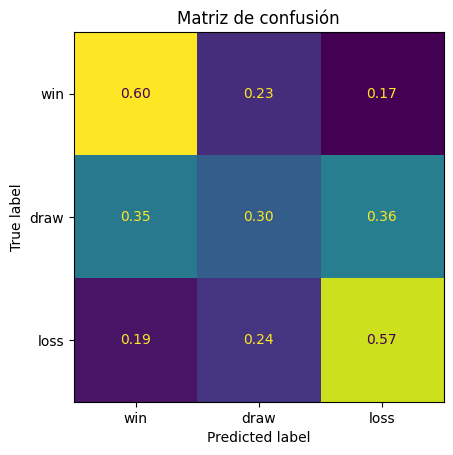


Resultados para KNN:

Accuracy: 0.547260060309868
F1-score (macro): 0.4456415748230742

Classification Report:
               precision    recall  f1-score   support

        draw       0.29      0.11      0.16      2194
        lose       0.50      0.49      0.49      2710
         win       0.61      0.78      0.68      4713

    accuracy                           0.55      9617
   macro avg       0.46      0.46      0.45      9617
weighted avg       0.50      0.55      0.51      9617



<Figure size 450x400 with 0 Axes>

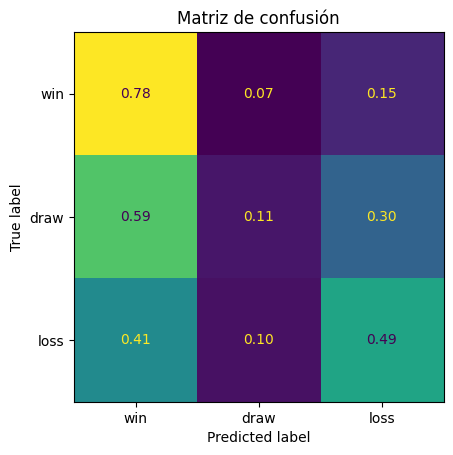


Resultados para SVC:

Accuracy: 0.5721118852032858
F1-score (macro): 0.4038747091930011

Classification Report:
               precision    recall  f1-score   support

        draw       0.00      0.00      0.00      2194
        lose       0.54      0.47      0.51      2710
         win       0.58      0.89      0.70      4713

    accuracy                           0.57      9617
   macro avg       0.37      0.46      0.40      9617
weighted avg       0.44      0.57      0.49      9617



<Figure size 450x400 with 0 Axes>

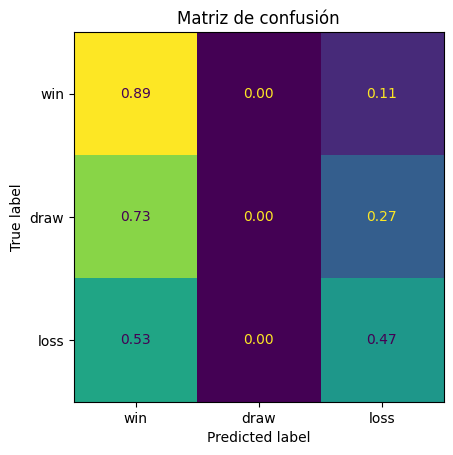


Resultados para Árbol de Decisión:

Accuracy: 0.48403868150150775
F1-score (macro): 0.467137446557381

Classification Report:
               precision    recall  f1-score   support

        draw       0.27      0.40      0.32      2194
        lose       0.47      0.52      0.49      2710
         win       0.70      0.51      0.59      4713

    accuracy                           0.48      9617
   macro avg       0.48      0.47      0.47      9617
weighted avg       0.54      0.48      0.50      9617



<Figure size 450x400 with 0 Axes>

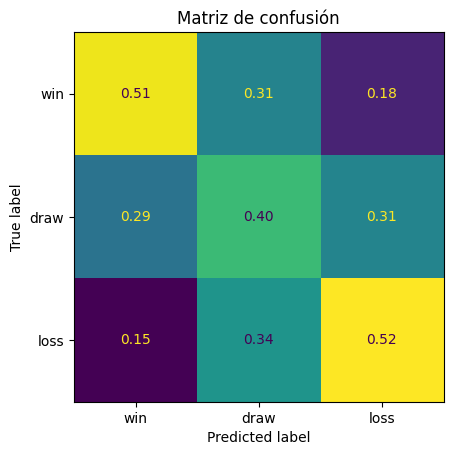


Resultados para Random Forest:

Accuracy: 0.5368618072163877
F1-score (macro): 0.4887211442609747

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.26      0.27      2194
        lose       0.51      0.56      0.53      2710
         win       0.67      0.65      0.66      4713

    accuracy                           0.54      9617
   macro avg       0.49      0.49      0.49      9617
weighted avg       0.54      0.54      0.54      9617



<Figure size 450x400 with 0 Axes>

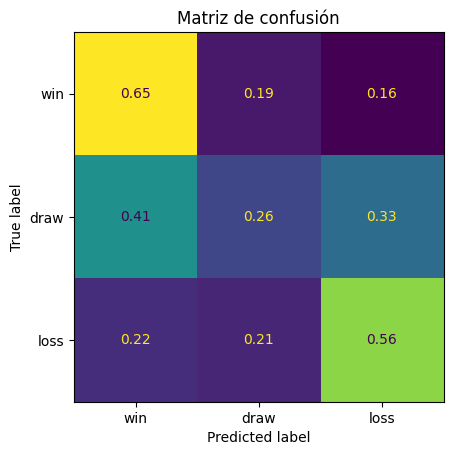

In [32]:
print_classification_results(y_te, y_pred_logreg, "Regresión Logística")
print_classification_results(y_te, y_pred_knn, "KNN")
print_classification_results(y_te, y_pred_svm, "SVC")
print_classification_results(y_te, y_pred_dtc, "Árbol de Decisión")
print_classification_results(y_te, y_pred_rfc, "Random Forest")

---

📝 No se obtuvieron resultados muy favorables. Algunas cosas a analizar:
- Hay cientos de equipos distintos (home/away). Pero cada par (home, away) puede haber jugado muy pocas veces entre sí, por tanto, el modelo no tiene ejemplos suficientes para aprender patrones específicos por par.
- La cantidad de observaciones puede ser insuficiente para entrenar los modelos.
- Alta cardinalidad de los tipos de torneos. Utilizar los mas conocidos o agrupar los menos conocidos en una sola categoria.

**Finalmente, observamos que es más conveniente utilizar un objetivo binario (win/no win). 
Contimuamos el análisis en el siguiente notebook**: [FIFA2026_win_nowin.ipynb](FIFA2026_win_nowin.ipynb)


